# Stock Price predictor



### Data Exploration

In [8]:
# Import libraries to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time, csv
from collections import defaultdict
from math import sqrt

In [9]:
# Load datasets & Analysis
TM_csv = './data/TM.csv'
dfTM = pd.read_csv(TM_csv, index_col='Date',parse_dates=True)    # Toyota Motor
# dfAP = pd.read_csv('./data/AAPL.csv', index_col='Date',parse_dates=True)  # Apple
# dfGE = pd.read_csv('./data/GE.csv', index_col='Date',parse_dates=True)    # General Electric
# dfMS = pd.read_csv('./data/MSFT.csv', index_col='Date',parse_dates=True)  # Microsoft
# dfSP = pd.read_csv('./data/^GSPC.csv', index_col='Date',parse_dates=True) # S&P 500
dfTM.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-24,123.779999,123.779999,122.309998,122.489998,98.390572,418000
2007-07-25,123.389999,123.410004,121.500000,122.290001,98.229897,557900
2007-07-26,122.320000,122.349998,117.050003,119.199997,95.747864,1258500
2007-07-27,121.739998,121.739998,119.040001,120.480003,96.776016,679900
2007-07-30,122.120003,122.599998,121.000000,121.790001,97.828300,639300


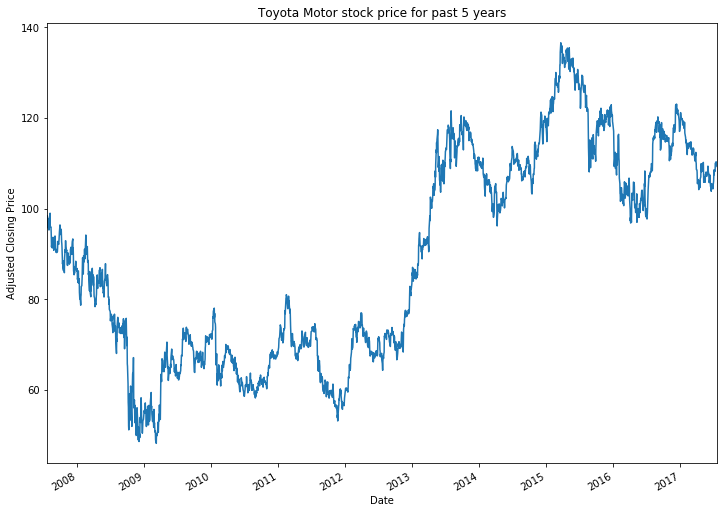

In [10]:
# Plot 'Date'(X-axis) and 'Adj Close'(Y-axis)
adj_close_TM = dfTM['Adj Close']
adj_close_TM = adj_close_TM.plot(figsize=(12, 9), title="Toyota Motor stock price for past 5 years")
adj_close_TM.set_ylabel("Adjusted Closing Price")

plt.show()

## Baseline model - Linear Regression

Training set has 2014 samples.
Testing set has 504 samples.
Coefficients: [ 0.02376277]
Mean Squared Error (MSE) 229.846382506
Variance score 0.566680730677
Root Mean Squared Error (RMSE) 15.1606854234


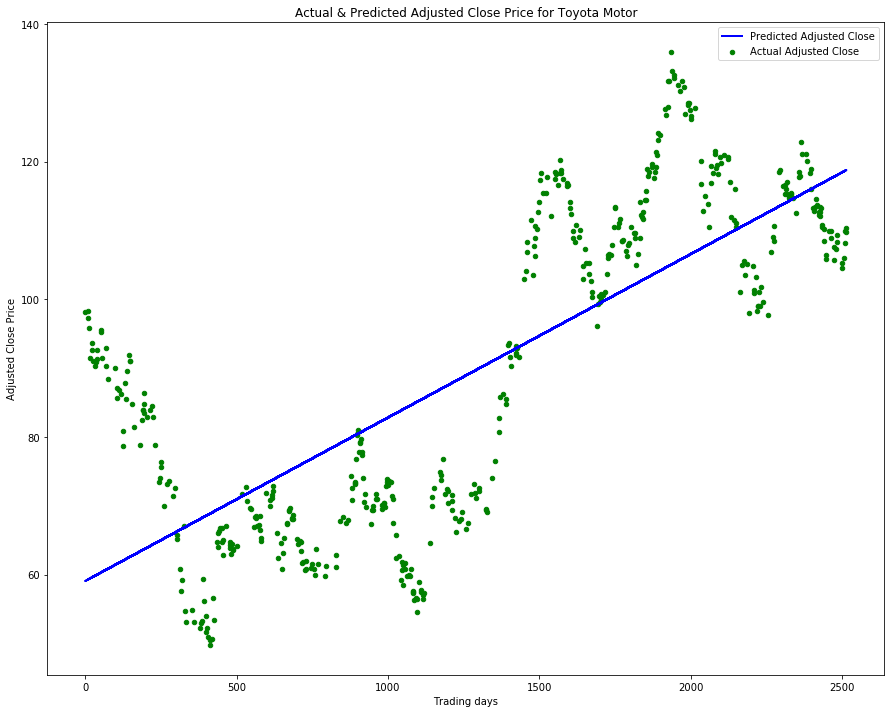

In [45]:
# Linear Regression model V.1 - Non normalized
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

# Load data (Toyota Motor) and split it into training and testing
data = pd.read_csv(TM_csv)
dates = pd.DataFrame(np.arange(2518))
adj_closes = data['Adj Close']
X_train, X_test, y_train, y_test = train_test_split(dates, adj_closes, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

regr = linear_model.LinearRegression()
regr.fit(X_train[:2014], y_train[:2014])

print 'Coefficients:', regr.coef_
print 'Mean Squared Error (MSE)', np.mean((regr.predict(X_test) - y_test) ** 2)
print 'Variance score', regr.score(X_test, y_test)
print 'Root Mean Squared Error (RMSE)', sqrt(np.mean((regr.predict(X_test) - y_test) ** 2))

# Plot outputs
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(X_test, y_test, color='g', s=20, label='Actual Adjusted Close')
plt.plot(X_test, regr.predict(X_test), color='b', linewidth=2, label='Predicted Adjusted Close')

plt.xlabel('Trading days')
plt.ylabel('Adjusted Close Price')

fig_size = plt.rcParams["figure.figsize"]
  
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

## Benchmark model - LSTM

### Before Improvement



In [59]:
# Load libraries
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

#### Helper functions

In [60]:
# Load only 'Adj Close' column from CSV
def load_adj_close():
    columns = defaultdict(list) # each value in each column is appended to a list

    with open('./data/TM.csv') as f:
        reader = csv.DictReader(f)    # read rows into a dictionary format
        for row in reader:            # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v)  # append the value into the appropriate list based on column name k

    return columns['Adj Close']

# Loading datasets and turn them into training and testing sets
def load_data(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Normalize function
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [61]:
# Get Adjusted Close price and split the data
adj_closes = load_adj_close()
X_train_, y_train_, X_test_, y_test_ = load_data(adj_closes, 50, True)

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
  if __name__ == '__main__':
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0444240570068
Train on 2109 samples, validate on 111 samples
Epoch 1/1
2109/2109 [==============================] - 12s - loss: 0.0062 - val_loss: 0.0022
Mean squared error (MSE) 0.00129839884097
Root Mean squared error (RMSE) 0.0360333018328


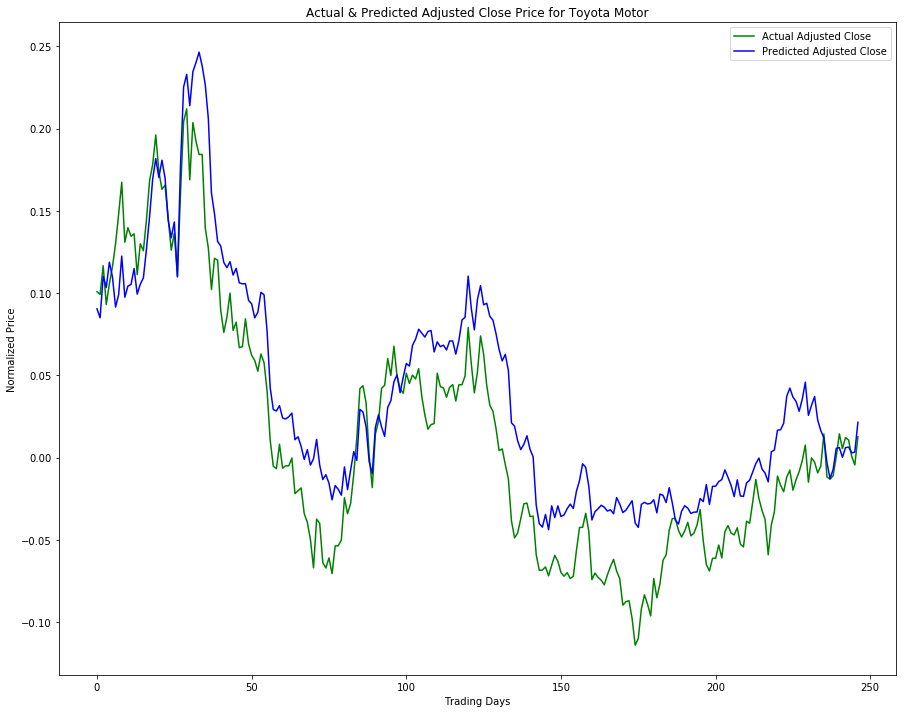

In [62]:
# LSTM Model

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=512,
    nb_epoch=1,
    validation_split=0.05)


testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

print 'Mean squared error (MSE)', score
print 'Root Mean squared error (RMSE)', math.sqrt(score)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### After Improvement